In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
%matplotlib inline

# In this notebook, we'll explore the properties of the dataset, see which features have a lot of information, and try to see what feature engineering we can do

In [2]:
train = pd.read_csv('train.csv')

In [5]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

### First look indicates the data set is pretty simple; we've got: 
- times and locations of both pickups and dropoffs (dropoff time will not be provided for test data)
- number of passengers
- vendor/trip ID
- the variable store_and_fwd_flag. Per the dataset description, "This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip"

The variable to be predicted is trip_duration. Let's see how this is distributed

In [31]:
train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

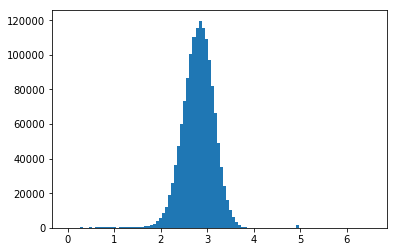

In [41]:
plt.hist(np.log10(train['trip_duration']), bins=100)
plt.show()

We've got a nice big data set here, but it does show some problems already. The shortest trip is 1 second long, and the longest trip is 3.5e6 seconds (over 40 days) long. Neither of those seem like real trips. Let's take a closer look at the outliers, first on the high end, then on the low end.

In [51]:
train.sort_values(by='trip_duration', ascending=False)[:10]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736
1234291,id1942836,2,2016-02-15 23:18:06,2016-02-16 23:17:58,2,-73.794525,40.644825,-73.991051,40.755573,N,86392
295382,id0593332,2,2016-05-31 13:00:39,2016-06-01 13:00:30,1,-73.781952,40.644688,-73.993874,40.745926,N,86391
73816,id0953667,2,2016-05-06 00:00:10,2016-05-07 00:00:00,1,-73.996010,40.753220,-73.979027,40.740601,N,86390
59891,id2837671,2,2016-06-30 16:37:52,2016-07-01 16:37:39,1,-73.992279,40.749729,-73.962524,40.800770,N,86387
1360439,id1358458,2,2016-06-23 16:01:45,2016-06-24 16:01:30,1,-73.782089,40.644806,-73.985016,40.666828,N,86385
753765,id2589925,2,2016-05-17 22:22:56,2016-05-18 22:22:35,4,-74.006111,40.734680,-73.958809,40.815449,N,86379


This shows that we have 4 clear outliers, with a bunch more sitting at almost 86,400 seconds -- which is exactly 1 day. This seems extremely suspicious. Furthermore, these trips don't look like they're very long, though data in degrees of latitude/longitude doesn't make it easy to tell.

In [53]:
train.sort_values(by='trip_duration', ascending=True)[:100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
207497,id1520236,1,2016-05-17 09:03:38,2016-05-17 09:03:39,1,-73.819893,40.740822,-73.819885,40.740822,N,1
1382872,id0839864,1,2016-02-06 13:40:27,2016-02-06 13:40:28,1,-73.987991,40.724083,-73.987991,40.724079,N,1
1360664,id0480433,1,2016-01-14 12:33:28,2016-01-14 12:33:29,1,-73.991486,40.741940,-73.991478,40.741955,N,1
346102,id2375785,1,2016-01-15 23:57:18,2016-01-15 23:57:19,1,-73.985825,40.755760,-73.985901,40.755829,N,1
1034341,id0218424,1,2016-01-17 13:50:16,2016-01-17 13:50:17,1,-73.953728,40.670036,-73.953346,40.670021,N,1
1439166,id2943073,2,2016-01-03 16:55:44,2016-01-03 16:55:45,1,-73.975677,40.785488,-73.976372,40.785831,N,1
35196,id2536510,1,2016-04-17 11:44:49,2016-04-17 11:44:50,1,-73.940384,40.786423,-73.940300,40.786373,N,1
918415,id0900936,2,2016-02-24 22:14:20,2016-02-24 22:14:21,1,-74.004005,40.745125,-74.003998,40.745144,N,1
767271,id0229521,1,2016-06-25 23:45:12,2016-06-25 23:45:13,1,-73.982925,40.738781,-73.982925,40.738781,N,1
810851,id1250016,1,2016-03-03 17:02:47,2016-03-03 17:02:48,1,-73.946075,40.705254,-73.946075,40.705254,N,1


Clearly we have a bunch of extremely short trips. Some of them look like non-trips since the starting locations are the same. Others move some. In any case, it's clear from both of these cases that we need better information about the distance for these trips. So let's add a column for distance.

There are a couple options for distance: as-the-crow-flies distance: ideally we'd have the distance the taxi actually drove, but this isn't directly available and would be very difficult to estimate without plugging them all in to google maps or equivalent. Much easier to calculate is either the Manhattan distance or the as-the-crow-flies distance. First we'll do the as-the-crow-flies distance, which can be calculated with the Haversine formula. Since we have over a million trips, this takes a while.

In [ ]:
R = 3959   #radius of earth in miles

def sind(x): return np.sin(np.pi * x/180)

def cosd(x): return np.cos(np.pi * x/180)

def a(row): 
    lat1 = row['pickup_latitude']
    lat2 = row['dropoff_latitude']
    long1 = row['pickup_longitude']
    long2 = row['dropoff_longitude']
    return (sind((lat2 - lat1)/2))**2 + cosd(lat1)*cosd(lat2)*(sind((long2-long1)/2))**2

train['a'] = train.apply(a, axis=1)

def c(row):
    train['c'] = 2 * np.arctan2(np.sqrt(row['a']), np.sqrt(1 - row['a']))
    
train['c'] = train.apply(c, axis=1)

train['crow_dist'] = train.apply(lambda row: R*row['c'], axis=1)

Intuitively, the store_and_fwd_flag, the vendor_id, and passenger_count probably won't have much information. Let's do some checks to see if we're right. First we'll look at the distribution of values in each of these variables

In [24]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

So almost all of those are N, but 8k 

In [22]:
print(np.mean(train[train['store_and_fwd_flag'] == 'N']['trip_duration']))
print(np.std(train[train['store_and_fwd_flag'] == 'N']['trip_duration']))
print(np.mean(train[train['store_and_fwd_flag'] == 'Y']['trip_duration']))
print(np.std(train[train['store_and_fwd_flag'] == 'Y']['trip_duration']))

958.8197055147563
5251.473033663491
1080.763331261653
925.5877861955322


In [23]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [7]:
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [49]:
(train['trip_duration'] > 16000).value_counts()

False    1456571
True        2073
Name: trip_duration, dtype: int64